## Coding Assignment Solution

###### Kunhong Yu (444447)

All solutions with modification will be commented with `## MODIFICATION`.

### I. Loading Packages and Setting Path

In [132]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from scipy.stats import gmean
from scipy import stats
import matplotlib.pyplot as plt

# Sets the path to the parent directory of RR classes
## MODIFICATION: Since we set our ipynb in the internal folder of RRClass, we don't set path here
path = '.'
file_path = osp.join(path, 'Data')
task_data_path = osp.join(file_path, 'onet_tasks.csv')
isco_data_path = osp.join(file_path, 'Eurostat_employment_isco.xlsx')

### II. Reading data

In [133]:
## MODIFICATION: Include reading data in a function
def read_data(data_path : str, sheet_name = None):
    """
    Read data into memory, we support csv and xlsx for this task
    Args : 
        --data_path: absolute path of data
        --sheet_name: if it is excel file, specify sheet_name
    return : 
        --read_data
    """
    suffix = data_path.split('.')[-1]
    assert suffix in ('csv', 'xlsx'), "Only csv or xlsx files supported!"
    if suffix.count('xlsx'): 
        assert sheet_name is not None, "Sheet name must be specified!"
    
    if suffix.count('csv'): # csv
        read_data = pd.read_csv(data_path)
    else: # xlsx
        read_data = pd.read_excel(data_path, sheet_name = sheet_name)
        
    return read_data

In [134]:
## MODIFICATION: Read task data using defined function
# Import data from the O*NET database, at ISCO-08 occupation level.
# The original data uses a version of SOC classification, but the data we load here
# are already cross-walked to ISCO-08 using: https://ibs.org.pl/en/resources/occupation-classifications-crosswalks-from-onet-soc-to-isco/

# The O*NET database contains information for occupations in the USA, including
# the tasks and activities typically associated with a specific occupation.
task_data = read_data(task_data_path, sheet_name = None)
task_data.head()
# isco08 variable is for occupation codes
# the t_* variables are specific tasks conducted on the job

,isco08,t_1A1f1,t_1A2a2,t_2B1a,t_4A2a4,t_4A2b2,t_4A3a3,t_4A3a4,t_4A4a1,t_4A4a4,...,t_4C3b7,t_4C3d3,t_4C3b8_rev,t_4C1a2l_rev,t_4A4a5_rev,t_4A4a8_rev,t_4A1b2_rev,t_4A3a2_rev,t_4A3b4_rev,t_4A3b5_rev
0,1112,1.561667,1.373333,3.916667,3.898333,3.806667,1.970000,2.206667,3.931667,4.376667,...,3.028333,1.370000,1.443333,1.193333,3.215000,2.353333,3.186667,4.023333,4.365000,4.381667
1,1113,1.185000,1.000000,4.000000,4.105000,4.180000,1.380000,1.420000,4.075000,4.390000,...,2.735000,1.390000,1.330000,1.130000,3.795000,2.950000,3.630000,4.520000,4.835000,4.805000
2,1114,1.416667,1.510000,3.750000,3.848333,3.457500,2.370833,2.370000,3.677500,4.052500,...,3.331667,1.488333,1.422500,1.225833,3.276667,2.597500,2.725833,3.767500,3.953333,4.114167
3,1120,1.342500,1.250000,4.000000,3.907500,3.750000,2.035000,1.910000,3.797500,4.165000,...,3.162500,1.495000,1.265000,1.090000,3.427500,2.550000,3.100000,4.015000,4.297500,4.432500
4,1211,1.000000,1.166667,3.290000,4.400000,3.603333,1.400000,1.130000,3.533333,4.026667,...,3.356667,1.180000,1.640000,1.110000,3.770000,3.570000,4.243333,4.686667,4.990000,4.883333


In [135]:
# read employment data from Eurostat
# These datasets include quarterly information on the number of workers in specific
# 1-digit ISCO occupation categories. (Check here for details: https://www.ilo.org/public/english/bureau/stat/isco/isco08/)
## MODIFICATION: Read Eurostat data sets, using defined function and a for loop
iscos = []
for i in range(1, 10):
    file = read_data(isco_data_path, sheet_name = i)
    iscos.append(file)
print(f'Length of iscos: {len(iscos)}.')

Length of iscos: 9.


### III. Data Preprocessing

In [136]:
## MODIFICAITON: Add a function to merge tables
def merge_tables(data_list : list, selected_countries : list):
    """
    Merging input tables
    Args : 
        --data_list: data list, containing all read data tables
        --selected_countries, list of strings, containing country names
    return : 
        --merged_data
    """
    # for loop to compute 'total' statistics
    # This will calculate worker totals in each of the chosen countries.
    totals = {}
    for country in selected_countries:
        total = 0.
        for i in range(len(data_list)):
            total += data_list[i][country]
            # We need a column that stores the occupation categories
            data_list[i]['ISCO'] = i + 1
        totals[f'total_{country}'] = total
        
    # now merging happens and this gives us one large file with employment in all occupations
    # in columns.
    merged_data = pd.concat(data_list, ignore_index = True)

    # We have 9 occupations and the same time range for each, so we can add the totals by
    # adding a vector that is 9 times the previously calculated totals
    for key, value in totals.items():
        merged_data[key] = pd.concat([value] * len(data_list), ignore_index = True)
        # And this will give us shares of each occupation among all workers in a period-country
        country = key.split('_')[-1]
        merged_data[f'share_{country}'] = merged_data[country] / merged_data[key]
        
    return merged_data

In [137]:
selected_countries = ['Belgium', 'Spain', 'Poland']
merged_data = merge_tables(data_list = iscos, selected_countries = selected_countries)
merged_data.head()

,TIME,European Union - 28 countries (2013-2020),Belgium,Czechia,Denmark,Spain,Italy,Lithuania,Poland,Finland,Sweden,ISCO,total_Belgium,share_Belgium,total_Spain,share_Spain,total_Poland,share_Poland
0,2011-Q1,12850.9,279.0,223.5,57.6,879.8,896.0,120.0,963.5,137.2,232.6,1,4391.5,0.063532,18169.2,0.048423,15027.1,0.064117
1,2011-Q2,12834.2,304.7,226.2,58.2,911.6,897.0,118.9,918.4,135.8,236.0,1,4472.2,0.068132,18373.4,0.049615,15245.5,0.060241
2,2011-Q3,12763.1,348.8,227.3,107.5,881.4,840.1,107.0,913.8,123.5,238.5,1,4428.3,0.078766,18241.4,0.048319,15353.6,0.059517
3,2011-Q4,12668.1,347.9,230.3,74.1,888.2,764.9,107.8,935.9,106.6,246.1,1,4473.3,0.077773,17896.2,0.049631,15260.8,0.061327
4,2012-Q1,12197.3,304.0,231.1,50.6,848.8,762.2,107.5,952.5,102.5,249.8,1,4426.3,0.068680,17509.0,0.048478,15055.5,0.063266


In [138]:
# Now let's look at the task data. We want the first digit of the ISCO variable only
task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)

# And we'll calculate the mean task values at a 1-digit level 
# (more on what these tasks are below)
aggdata = task_data.groupby(["isco08_1dig"]).mean()
aggdata = aggdata.drop(columns = ["isco08"])
aggdata.head()

,t_1A1f1,t_1A2a2,t_2B1a,t_4A2a4,t_4A2b2,t_4A3a3,t_4A3a4,t_4A4a1,t_4A4a4,t_4A4b4,...,t_4C3b7,t_4C3d3,t_4C3b8_rev,t_4C1a2l_rev,t_4A4a5_rev,t_4A4a8_rev,t_4A1b2_rev,t_4A3a2_rev,t_4A3b4_rev,t_4A3b5_rev
isco08_1dig,,,,,,,,,,,,,,,,,,,,,
1,1.326454,1.636667,3.695167,3.839380,3.666472,2.125769,2.088917,3.592583,4.117944,3.829750,...,3.265843,1.518102,1.567000,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
2,1.209633,1.798065,3.451530,3.820819,3.878887,1.997723,1.675662,3.789617,4.041019,3.055094,...,2.928302,1.292766,1.805717,1.359710,3.180703,2.888332,3.417922,3.878642,4.461316,4.249600
3,1.505226,2.514247,3.236644,3.452869,3.276176,2.729089,2.346285,3.341765,3.807574,2.842918,...,3.555429,1.873488,1.910562,1.332013,3.045600,2.923582,2.744621,3.146627,3.915928,3.834438
4,1.142259,1.985481,3.101111,3.056160,2.761074,2.089852,1.657481,3.012790,3.841049,2.345556,...,4.202296,1.721519,2.103778,1.523642,3.168716,2.798074,3.628111,3.597778,4.494481,4.272111
5,1.558771,2.494823,3.323650,2.754905,3.084312,2.446784,2.317294,2.902676,3.765301,2.923502,...,3.102737,1.610852,2.133569,1.534147,2.665190,2.195358,2.948306,2.973971,4.011690,4.060046


In [139]:
# We'll be interested in tracking the intensity of Non-routine cognitive analytical tasks
# Using a framework reminiscent of the work by David Autor.
#These are the ones we're interested in:
# Non-routine cognitive analytical
# 4.A.2.a.4 Analyzing Data or Information
# 4.A.2.b.2 Thinking Creatively
# 4.A.4.a.1 Interpreting the Meaning of Information for Others
#Let's combine the data.
combined = pd.merge(merged_data, aggdata, left_on = 'ISCO', right_on = 'isco08_1dig', 
                    how = 'left') # left join
combined.head()

,TIME,European Union - 28 countries (2013-2020),Belgium,Czechia,Denmark,Spain,Italy,Lithuania,Poland,Finland,...,t_4C3b7,t_4C3d3,t_4C3b8_rev,t_4C1a2l_rev,t_4A4a5_rev,t_4A4a8_rev,t_4A1b2_rev,t_4A3a2_rev,t_4A3b4_rev,t_4A3b5_rev
0,2011-Q1,12850.9,279.0,223.5,57.6,879.8,896.0,120.0,963.5,137.2,...,3.265843,1.518102,1.567,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
1,2011-Q2,12834.2,304.7,226.2,58.2,911.6,897.0,118.9,918.4,135.8,...,3.265843,1.518102,1.567,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
2,2011-Q3,12763.1,348.8,227.3,107.5,881.4,840.1,107.0,913.8,123.5,...,3.265843,1.518102,1.567,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
3,2011-Q4,12668.1,347.9,230.3,74.1,888.2,764.9,107.8,935.9,106.6,...,3.265843,1.518102,1.567,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
4,2012-Q1,12197.3,304.0,231.1,50.6,848.8,762.2,107.5,952.5,102.5,...,3.265843,1.518102,1.567,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759


In [140]:
# Traditionally, the first step is to standardise the task values using weights 
# defined by share of occupations in the labour force. This should be done separately
# for each country. Standardisation -> getting the mean to 0 and std. dev. to 1.
# Let's do this for each of the variables that interests us:
## MODIFICATION: Add normalize_data function to perform z-score preprocessing
def normalize_data(data, column_name : str, weight_column_names : list):
    """
    Nomalize data set using z-score
    Args : 
        --data: input combined data
        --column_name
        --weight_column_names: a list contains all weight columns
    return : 
        --one-column-normalized data
    """
    for weight_column_name in weight_column_names: # loop through weights
        country = weight_column_name.split('_')[-1]
        mean = np.average(data[column_name], weights = data[weight_column_name])
        sd = np.sqrt(np.average((data[column_name] - mean) ** 2,
                                weights = data[weight_column_name]))
        if column_name.count(country):
            new_column_name = f'std_{column_name}'
        else:
            new_column_name = f'std_{country}_{column_name}'
        data[new_column_name] = (data[column_name] - mean) / sd # add new normalized column with its weight
    
    return data

In [141]:
## MODIFICATION: For loop through all possible columns 
columns = ['t_4A2a4', 't_4A2b2', 't_4A4a1']
weight_columns = ['share_Belgium', 'share_Poland', 'share_Spain']

combined2 = combined.copy() # copy data

for column_name in columns: # loop through columns
    print(f'Normalizing {column_name}...')
    combined2 = normalize_data(combined2, column_name = column_name,
                               weight_column_names = weight_columns) # normalize
    
combined2.head()

Normalizing t_4A2a4...
Normalizing t_4A2b2...
Normalizing t_4A4a1...


,TIME,European Union - 28 countries (2013-2020),Belgium,Czechia,Denmark,Spain,Italy,Lithuania,Poland,Finland,...,t_4A3b5_rev,std_Belgium_t_4A2a4,std_Poland_t_4A2a4,std_Spain_t_4A2a4,std_Belgium_t_4A2b2,std_Poland_t_4A2b2,std_Spain_t_4A2b2,std_Belgium_t_4A4a1,std_Poland_t_4A4a1,std_Spain_t_4A4a1
0,2011-Q1,12850.9,279.0,223.5,57.6,879.8,896.0,120.0,963.5,137.2,...,4.270759,1.283003,1.510081,1.639543,0.941598,1.120186,1.227219,0.931835,1.148909,1.238556
1,2011-Q2,12834.2,304.7,226.2,58.2,911.6,897.0,118.9,918.4,135.8,...,4.270759,1.283003,1.510081,1.639543,0.941598,1.120186,1.227219,0.931835,1.148909,1.238556
2,2011-Q3,12763.1,348.8,227.3,107.5,881.4,840.1,107.0,913.8,123.5,...,4.270759,1.283003,1.510081,1.639543,0.941598,1.120186,1.227219,0.931835,1.148909,1.238556
3,2011-Q4,12668.1,347.9,230.3,74.1,888.2,764.9,107.8,935.9,106.6,...,4.270759,1.283003,1.510081,1.639543,0.941598,1.120186,1.227219,0.931835,1.148909,1.238556
4,2012-Q1,12197.3,304.0,231.1,50.6,848.8,762.2,107.5,952.5,102.5,...,4.270759,1.283003,1.510081,1.639543,0.941598,1.120186,1.227219,0.931835,1.148909,1.238556


In [142]:
# The next step is to calculate the `classic` task content intensity, i.e.
# how important is a particular general task content category in the workforce
# Here, we're looking at non-routine cognitive analytical tasks, as defined
# by David Autor and Darron Acemoglu:
## MODIFICATION: Using a for loop here
for country in selected_countries: # loop through countries
    combined2[f'{country}_NRCA'] = 0.
    for column_name in columns: # loop every column we chose before
        combined2[f'{country}_NRCA'] += combined2[f'std_{country}_{column_name}'] 
        
combined2.head()

,TIME,European Union - 28 countries (2013-2020),Belgium,Czechia,Denmark,Spain,Italy,Lithuania,Poland,Finland,...,std_Spain_t_4A2a4,std_Belgium_t_4A2b2,std_Poland_t_4A2b2,std_Spain_t_4A2b2,std_Belgium_t_4A4a1,std_Poland_t_4A4a1,std_Spain_t_4A4a1,Belgium_NRCA,Spain_NRCA,Poland_NRCA
0,2011-Q1,12850.9,279.0,223.5,57.6,879.8,896.0,120.0,963.5,137.2,...,1.639543,0.941598,1.120186,1.227219,0.931835,1.148909,1.238556,3.156436,4.105319,3.779176
1,2011-Q2,12834.2,304.7,226.2,58.2,911.6,897.0,118.9,918.4,135.8,...,1.639543,0.941598,1.120186,1.227219,0.931835,1.148909,1.238556,3.156436,4.105319,3.779176
2,2011-Q3,12763.1,348.8,227.3,107.5,881.4,840.1,107.0,913.8,123.5,...,1.639543,0.941598,1.120186,1.227219,0.931835,1.148909,1.238556,3.156436,4.105319,3.779176
3,2011-Q4,12668.1,347.9,230.3,74.1,888.2,764.9,107.8,935.9,106.6,...,1.639543,0.941598,1.120186,1.227219,0.931835,1.148909,1.238556,3.156436,4.105319,3.779176
4,2012-Q1,12197.3,304.0,231.1,50.6,848.8,762.2,107.5,952.5,102.5,...,1.639543,0.941598,1.120186,1.227219,0.931835,1.148909,1.238556,3.156436,4.105319,3.779176


In [143]:
## MODIFICATION: Use defined normalize_data function again and for loop
columns = ['Belgium_NRCA', 'Poland_NRCA', 'Spain_NRCA']
weight_columns = ['share_Belgium', 'share_Poland', 'share_Spain']

combined3 = combined2.copy() # copy data

for column_name, weight_column in zip(columns, weight_columns): # loop through columns
    print(f'Normalizing {column_name}...')
    combined3 = normalize_data(combined3, column_name = column_name,
                               weight_column_names = [weight_column]) # normalize
    
combined3.head()

Normalizing Belgium_NRCA...
Normalizing Poland_NRCA...
Normalizing Spain_NRCA...


,TIME,European Union - 28 countries (2013-2020),Belgium,Czechia,Denmark,Spain,Italy,Lithuania,Poland,Finland,...,std_Spain_t_4A2b2,std_Belgium_t_4A4a1,std_Poland_t_4A4a1,std_Spain_t_4A4a1,Belgium_NRCA,Spain_NRCA,Poland_NRCA,std_Belgium_NRCA,std_Poland_NRCA,std_Spain_NRCA
0,2011-Q1,12850.9,279.0,223.5,57.6,879.8,896.0,120.0,963.5,137.2,...,1.227219,0.931835,1.148909,1.238556,3.156436,4.105319,3.779176,1.078676,1.290898,1.407656
1,2011-Q2,12834.2,304.7,226.2,58.2,911.6,897.0,118.9,918.4,135.8,...,1.227219,0.931835,1.148909,1.238556,3.156436,4.105319,3.779176,1.078676,1.290898,1.407656
2,2011-Q3,12763.1,348.8,227.3,107.5,881.4,840.1,107.0,913.8,123.5,...,1.227219,0.931835,1.148909,1.238556,3.156436,4.105319,3.779176,1.078676,1.290898,1.407656
3,2011-Q4,12668.1,347.9,230.3,74.1,888.2,764.9,107.8,935.9,106.6,...,1.227219,0.931835,1.148909,1.238556,3.156436,4.105319,3.779176,1.078676,1.290898,1.407656
4,2012-Q1,12197.3,304.0,231.1,50.6,848.8,762.2,107.5,952.5,102.5,...,1.227219,0.931835,1.148909,1.238556,3.156436,4.105319,3.779176,1.078676,1.290898,1.407656


In [144]:
# Finally, to track the changes over time, we have to calculate a country-level mean
# Step 1: multiply the value by the share of such workers.
## MODIFICATION: Use for loop
for country in selected_countries:
    combined3[f'multip_{country}_NRCA'] = combined3[f'std_{country}_NRCA'] * combined3[f'share_{country}']
    
# Step 2: sum it up (it basically becomes another weighted mean)
## MODIFICATION: Use for loop
aggs = []
for country in selected_countries:
    temp = combined3.groupby(["TIME"])[f"multip_{country}_NRCA"].sum().reset_index()
    aggs.append(temp)

combined3.head()

,TIME,European Union - 28 countries (2013-2020),Belgium,Czechia,Denmark,Spain,Italy,Lithuania,Poland,Finland,...,std_Spain_t_4A4a1,Belgium_NRCA,Spain_NRCA,Poland_NRCA,std_Belgium_NRCA,std_Poland_NRCA,std_Spain_NRCA,multip_Belgium_NRCA,multip_Spain_NRCA,multip_Poland_NRCA
0,2011-Q1,12850.9,279.0,223.5,57.6,879.8,896.0,120.0,963.5,137.2,...,1.238556,3.156436,4.105319,3.779176,1.078676,1.290898,1.407656,0.068530,0.068162,0.082769
1,2011-Q2,12834.2,304.7,226.2,58.2,911.6,897.0,118.9,918.4,135.8,...,1.238556,3.156436,4.105319,3.779176,1.078676,1.290898,1.407656,0.073492,0.069841,0.077765
2,2011-Q3,12763.1,348.8,227.3,107.5,881.4,840.1,107.0,913.8,123.5,...,1.238556,3.156436,4.105319,3.779176,1.078676,1.290898,1.407656,0.084963,0.068016,0.076830
3,2011-Q4,12668.1,347.9,230.3,74.1,888.2,764.9,107.8,935.9,106.6,...,1.238556,3.156436,4.105319,3.779176,1.078676,1.290898,1.407656,0.083891,0.069863,0.079167
4,2012-Q1,12197.3,304.0,231.1,50.6,848.8,762.2,107.5,952.5,102.5,...,1.238556,3.156436,4.105319,3.779176,1.078676,1.290898,1.407656,0.074084,0.068240,0.081670


### IV. Plotting

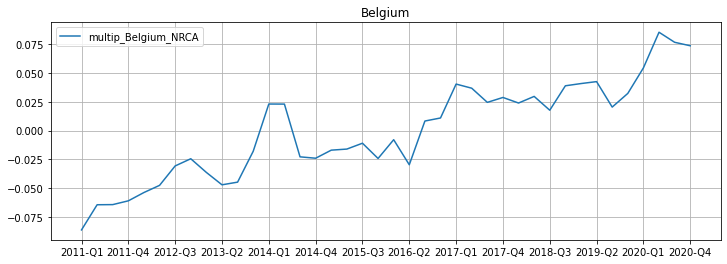

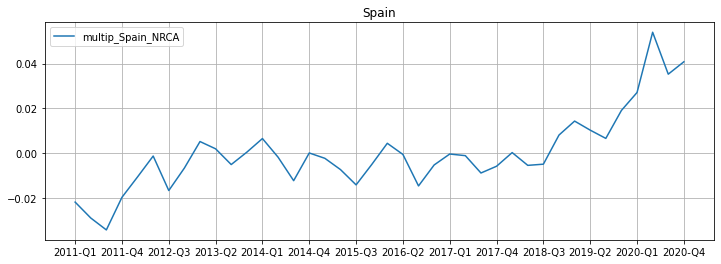

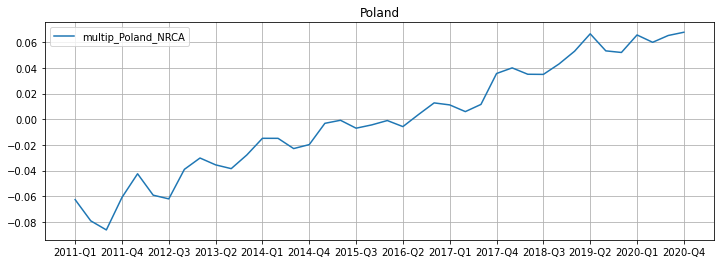

In [52]:
## MODIFICATION: Use for loop
for agg, country in zip(aggs, selected_countries):
    fig = plt.figure(figsize = (12, 4))
    plt.plot(agg["TIME"], agg[f"multip_{country}_NRCA"], label = f"multip_{country}_NRCA")
    plt.xticks(range(0, len(agg), 3), agg["TIME"][::3])
    plt.title(country)
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()